# 고객 행동 예측

### 고객의 소리 (VOC)
- 고객별 이용 횟수가 예측됐느냐?


- use_log.csv 
- customer_join.csv

### 데이터 읽어오고 확인

In [1]:
import pandas as pd

In [3]:
uselog = pd.read_csv('use_log.csv')
uselog.isnull().sum() / len(uselog)

log_id         0.0
customer_id    0.0
usedate        0.0
dtype: float64

In [4]:
uselog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 3 columns):
log_id         197428 non-null object
customer_id    197428 non-null object
usedate        197428 non-null object
dtypes: object(3)
memory usage: 4.5+ MB


In [6]:
customer = pd.read_csv('customer_join.csv')

In [7]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4192 entries, 0 to 4191
Data columns (total 18 columns):
customer_id          4192 non-null object
name                 4192 non-null object
class                4192 non-null object
gender               4192 non-null object
start_date           4192 non-null object
end_date             1350 non-null object
campaign_id          4192 non-null object
is_deleted           4192 non-null int64
class_name           4192 non-null object
price                4192 non-null int64
campaign_name        4192 non-null object
mean                 4192 non-null float64
median               4192 non-null float64
max                  4192 non-null int64
min                  4192 non-null int64
routine_flg          4192 non-null int64
calc_date            4192 non-null object
membership_period    4192 non-null int64
dtypes: float64(2), int64(6), object(10)
memory usage: 589.6+ KB


### 클러스터링으로 회원을 그룹화
- 탈퇴 여부로 분류하는 것이 아니라 이용 이력을 통해 그룹화
- 진짜 결측인지, 탈퇴하지 않은 것인지 부정확하기 때문에

In [8]:
customer_clustering = customer[['mean','median','min','max','membership_period']]
customer_clustering.head(3)

,mean,median,min,max,membership_period
0,4.833333,5.0,2,8,47
1,5.083333,5.0,3,7,47
2,4.583333,5.0,3,6,47


In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [11]:
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

In [12]:
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)

In [13]:
customer_clustering['cluster'] = clusters.labels_

In [14]:
customer_clustering['cluster'].unique()

array([1, 2, 3, 0], dtype=int64)

In [15]:
customer_clustering.head(3)

,mean,median,min,max,membership_period,cluster
0,4.833333,5.0,2,8,47,1
1,5.083333,5.0,3,7,47,1
2,4.583333,5.0,3,6,47,1


In [16]:
customer_clustering.columns = ['월평균값', '월중앙값', '월최대값', '월최소값', '회원기간', 'cluster']
customer_clustering.groupby('cluster').count()

,월평균값,월중앙값,월최대값,월최소값,회원기간
cluster,,,,,
0,841,841,841,841,841
1,1248,1248,1248,1248,1248
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


In [17]:
## 그룹 0 : 평균 이용 횟수가 높고 기간이 짧다.  -> 막 가입한 회원
# 그룹 1 : 평균 이용 횟수가 적고 기간이 길다. -> 안정적인 회원
# 그룹 2: 평균 이용횟수가 적고 기간이 짧다. -> 번아웃 상태
# 그룹 3 : 평균 이용횟수가 보통이고, 기간이 길다. -> 고인물

customer_clustering.groupby('cluster').mean()

,월평균값,월중앙값,월최대값,월최소값,회원기간
cluster,,,,,
0,8.061076,8.046373,6.171225,10.015458,7.027348
1,4.677436,4.671074,2.153045,7.233173,36.925481
2,3.065504,2.900130,1.649805,4.783398,9.276265
3,5.537658,5.388889,2.702703,8.753754,14.876126


## 클러스터링 결과 시각화
- 5개의 변수를 2차원으로 차원 축소 진행 


In [18]:
from sklearn.decomposition import PCA

In [19]:
X = customer_clustering_sc
pca =  PCA(n_components=2)

X_pca = pca.fit_transform(X)
X_pca



array([[-0.81998232, -1.95909657],
       [-0.70792183, -1.79985685],
       [-1.06149902, -1.65982605],
       ...,
       [ 3.02793307,  1.13963534],
       [ 6.08311415,  0.58470806],
       [ 5.06472045,  0.76968382]])

In [20]:
pca_df = pd.DataFrame(X_pca)

In [21]:
pca_df

,0,1
0,-0.819982,-1.959097
1,-0.707922,-1.799857
2,-1.061499,-1.659826
3,-1.160764,-1.810139
4,-2.017132,-1.670101
...,...,...
4187,3.027933,1.139635
4188,5.064720,0.769684
4189,3.027933,1.139635
4190,6.083114,0.584708


In [22]:
pca_df['cluster'] = customer_clustering['cluster']

In [23]:
pca_df.head()

,0,1,cluster
0,-0.819982,-1.959097,1
1,-0.707922,-1.799857,1
2,-1.061499,-1.659826,1
3,-1.160764,-1.810139,1
4,-2.017132,-1.670101,1


In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

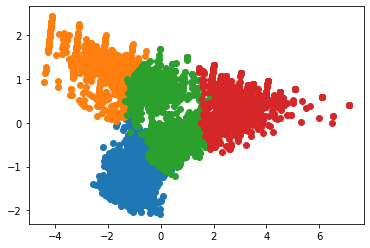

In [25]:
for i in customer_clustering['cluster'].unique():
    tmp = pca_df.loc[pca_df['cluster'] == i, :]
    plt.scatter(tmp[0], tmp[1])

## 클러스터링 결과를 바탕으로 탈퇴회원 경향 분석
- 지속회원과 탈퇴회원을 집계

In [26]:
customer_clustering = pd.concat([customer_clustering, customer], axis = 1)

In [27]:
customer_clustering.head(3)

,월평균값,월중앙값,월최대값,월최소값,회원기간,cluster,customer_id,name,class,gender,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,4.833333,5.0,2,8,47,1,OA832399,XXXX,C01,F,...,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,5.083333,5.0,3,7,47,1,PL270116,XXXXX,C01,M,...,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,4.583333,5.0,3,6,47,1,OA974876,XXXXX,C01,M,...,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47


In [ ]:
## 그룹 0 : 평균 이용 횟수가 높고 기간이 짧다.  -> 막 가입한 회원
# 그룹 1 : 평균 이용 횟수가 적고 기간이 길다. -> 안정적인 회원
# 그룹 2: 평균 이용횟수가 적고 기간이 짧다. -> 번아웃 상태 / 알고보니 탈퇴회원이었다.
# 그룹 3 : 평균 이용횟수가 보통이고, 기간이 길다. -> 고인물

In [30]:
customer_clustering.groupby(['cluster', 'is_deleted'], as_index=False).count()[['cluster', 'is_deleted', 'customer_id']]
## 일반, 탈퇴 회원 관한 테이블

,cluster,is_deleted,customer_id
0,0,0,822
1,0,1,19
2,1,0,1230
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


In [31]:
customer_clustering.groupby(['cluster', 'routine_flg'], as_index=False).count()[['cluster', 'routine_flg', 'customer_id']]
## 정기, 비정기 회원 집계

,cluster,routine_flg,customer_id
0,0,0,52
1,0,1,789
2,1,0,2
3,1,1,1246
4,2,0,499
5,2,1,272
6,3,0,226
7,3,1,1106


In [ ]:
## 정기 비정기 회원 집계
## 그룹 1, 3은 정기적으로 이용하는 회원 수가 많다는 것을 알 수 있다. 

### 다음달의 이용횟수 예측을 위해 데이터 전처리
- 2018년 10월이고, 2018년 11월 이용 횟수를 예측한다고 하면, 2018년 11월 이후에 데이터는 의미가 전혀 없다. 
- 2018년 05월 ~ 10월까지 6개월의 이용 데이터와 2018년 11월 이용 횟수 데이터가 필요하다. 
- 특정 월별 데이터가 필요함

In [36]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['연월'] = uselog['usedate'].dt.strftime('%Y%m')
uselog_months = uselog.groupby(['연월', 'customer_id'], as_index = False).count()


In [41]:
uselog.groupby(['연월', 'customer_id'], as_index = False).count()

,연월,customer_id,log_id,usedate
0,201804,AS002855,4,4
1,201804,AS009013,2,2
2,201804,AS009373,3,3
3,201804,AS015315,6,6
4,201804,AS015739,7,7
...,...,...,...,...
36837,201903,TS995853,8,8
36838,201903,TS998593,8,8
36839,201903,TS999079,3,3
36840,201903,TS999231,6,6


In [43]:
uselog_months.rename(columns = {'log_id':'count'}, inplace = True)
del uselog_months['usedate']
uselog_months.head(3)

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3


In [44]:
# 이번달 기준으로 과거 5개월치 이용 횟수와 다음달 이용횟수 데이터 정리
year_months = list(uselog_months['연월'].unique())

In [45]:
year_months

['201804',
 '201805',
 '201806',
 '201807',
 '201808',
 '201809',
 '201810',
 '201811',
 '201812',
 '201901',
 '201902',
 '201903']

In [49]:
predict_data = pd.DataFrame()

In [50]:
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months['연월'] == year_months[i], :]
    tmp.rename(columns = {'count': 'count_pred'}, inplace = True)
    for j in range(1,7):
        tmp_before = uselog_months.loc[uselog_months['연월'] == year_months[i-j], :]
        del tmp_before['연월']
        tmp_before.rename(columns = {'count':'count_{}'.format(j-1)}, inplace = True)
        tmp = pd.merge(tmp, tmp_before, on = 'customer_id', how = 'left')
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)

In [51]:
predict_data

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
...,...,...,...,...,...,...,...,...,...
18305,201903,TS995853,8,11.0,NaN,NaN,NaN,NaN,NaN
18306,201903,TS998593,8,7.0,8.0,7.0,9.0,9.0,9.0
18307,201903,TS999079,3,2.0,6.0,9.0,6.0,6.0,4.0
18308,201903,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0


In [52]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop= True)
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


### 특징이 되는 변수를 추가 
- 시계열 변화를 볼 수 있는 회원기간
- 현재 계속 다니고 있는 회원들의 회원가입 절차

In [53]:
predict_data = pd.merge(predict_data, customer[['customer_id', 'start_date']], on = 'customer_id', how = 'left')
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [54]:
predict_data['now_date'] = pd.to_datetime(predict_data['연월'], format = '%Y%m')
predict_data['start_date'] = pd.to_datetime(predict_data['start_date'])

In [55]:
from dateutil.relativedelta import relativedelta

In [56]:
predict_data['period'] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data['now_date'][i], predict_data['start_date'][i])
    predict_data['period'][i] = delta.years*12 + delta.months

In [57]:
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


### 다음달 이용횟수를 예측하는 모델 추측
- Linear Regression을 이용 

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [59]:
predict_data.shape

(15113, 12)

In [60]:
predict_data = predict_data.loc[predict_data['start_date'] >= pd.to_datetime('20180401'), :]

In [61]:
predict_data.shape

(1702, 12)